In [1]:
#Import Library yang dibutuhkan
import yfinance as yf
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
# Mute general warnings
import warnings
warnings.filterwarnings('ignore')

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.arima.model import ARIMA

### Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Dropout,Dense

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
data = yf.download("STX4847-USD", start="2021-01-01", end="2024-02-01")

### Displaying first 5 rows
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,0.396171,0.445632,0.395665,0.430350,0.430350,7894633
2021-01-02,0.427812,0.485016,0.426783,0.456179,0.456179,5731346
2021-01-03,0.456739,0.527572,0.454222,0.480653,0.480653,168850
2021-01-04,0.479029,0.507158,0.422383,0.490973,0.490973,5349514
2021-01-05,0.489835,0.543781,0.456598,0.521651,0.521651,5921306
...,...,...,...,...,...,...
2024-01-27,1.508453,1.544160,1.497605,1.513569,1.513569,65039391
2024-01-28,1.514008,1.563102,1.460550,1.473947,1.473947,75911922
2024-01-29,1.474390,1.563435,1.444286,1.538763,1.538763,82187571


In [3]:
#Memeriksa Kolom
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
# Mengecek Missing Values
missing_values = data.isnull().sum()
print("Jumlah Missing Values untuk Setiap Kolom:")
print(missing_values)

Jumlah Missing Values untuk Setiap Kolom:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=data.index,
                      open=data.Open,
                      high=data.High,
                      low=data.Low,
                      close=data.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=data.index, y=data.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [6]:
data.shape

(1126, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1126 entries, 2021-01-01 to 2024-01-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1126 non-null   float64
 1   High       1126 non-null   float64
 2   Low        1126 non-null   float64
 3   Close      1126 non-null   float64
 4   Adj Close  1126 non-null   float64
 5   Volume     1126 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 61.6 KB


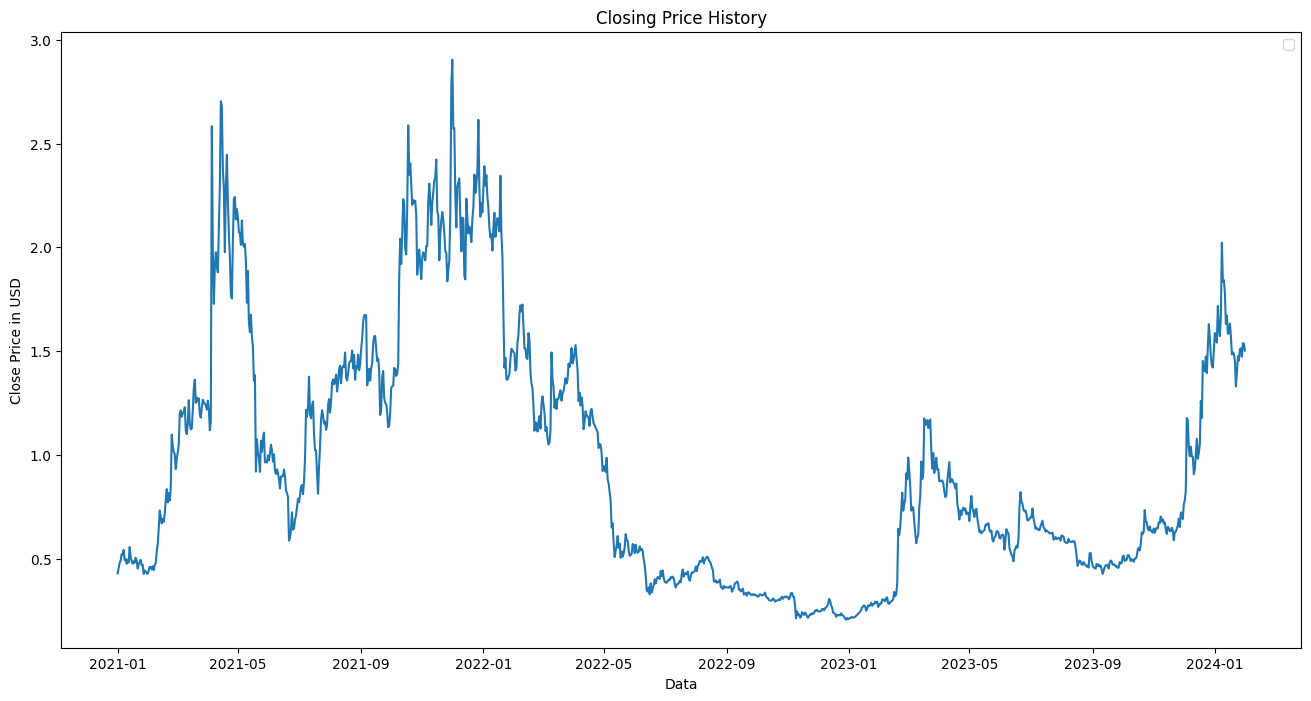

In [8]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(data['Close'])
plt.xlabel("Data")
plt.ylabel("Close Price in USD")
plt.legend()
plt.show()

Harga meningkat secara signifikan dari tahun ke tahun, tetapi sempat menurung pada tahun 2020.

In [9]:
### Considering the Closing Price only
df=data["Close"].values

### Converting the array into a 2-D one
df=np.reshape(df,(-1,1))

In [10]:
### Scaling the data
### Menggunakan Standard Scaler yaitu MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
df_scaled=sc.fit_transform(df)
df_scaled[:10]

array([[0.0828717 ],
       [0.09244958],
       [0.10152499],
       [0.10535185],
       [0.11672784],
       [0.11692473],
       [0.12447941],
       [0.10665268],
       [0.10859726],
       [0.09972652]])

In [11]:
### Using 80% as the Train data::
l=math.ceil(len(df_scaled)*0.8)
trained_data=df_scaled[0:l,:]
trained_data[:10]

array([[0.0828717 ],
       [0.09244958],
       [0.10152499],
       [0.10535185],
       [0.11672784],
       [0.11692473],
       [0.12447941],
       [0.10665268],
       [0.10859726],
       [0.09972652]])

In [12]:
n_steps=60  ### time step variable :
X_train=[]
y_train=[]

for i in range(n_steps,len(trained_data)):
    X_train.append(trained_data[i-n_steps:i,0])
    y_train.append(trained_data[i,0])

In [13]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [14]:
### Test data to see the model performance::
test_data=df_scaled[l-n_steps:,:]

X_test=[]
y_test=df_scaled[l:,:]
for i in range(n_steps,len(test_data)):
    X_test.append(test_data[i-n_steps:i,0])

X_test=np.array(X_test)

In [15]:
### Reshaping the input data into (n_rows,window_size,1)
### This is the standard format to LSTMs and GRUs:
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))  ### Reshaping the Test data as well to satisfy input requirements:)

In [16]:
### we will evaluate the model using a custom loss function which will calculate MAPE:
def mape(y_true, y_pred):
    # calculate loss, using y_pred
    loss=np.mean(np.abs((y_pred/y_true)-1))
    return loss

In [17]:
## Architecture of RNN using stacked LSTMs:
model1=Sequential([
                 LSTM(1000,return_sequences=True,input_shape=(X_train.shape[1],1)),
                 LSTM(500,return_sequences=True),
                 LSTM(100,return_sequences=False),
                 Dense(25),
                 Dense(1)
])

model1.compile(optimizer="adam",loss="mean_squared_error")

## Architecture of RNN using stacked GRUs:
model2=Sequential([
                 GRU(1000,return_sequences=True,input_shape=(X_train.shape[1],1)),
                 GRU(500,return_sequences=True),
                 GRU(100,return_sequences=False),
                 Dense(25),
                 Dense(1)
])

model2.compile(optimizer="adam",loss="mean_squared_error")

Epoch 1/10
27/27 [==============================] - 125s 4s/step - loss: 0.0507
Epoch 2/10
27/27 [==============================] - 116s 4s/step - loss: 0.0060
Epoch 3/10
27/27 [==============================] - 112s 4s/step - loss: 0.0046
Epoch 4/10
27/27 [==============================] - 115s 4s/step - loss: 0.0046
Epoch 5/10
27/27 [==============================] - 113s 4s/step - loss: 0.0044
Epoch 6/10
27/27 [==============================] - 115s 4s/step - loss: 0.0036
Epoch 7/10
27/27 [==============================] - 113s 4s/step - loss: 0.0035
Epoch 8/10
27/27 [==============================] - 116s 4s/step - loss: 0.0031
Epoch 9/10
27/27 [==============================] - 115s 4s/step - loss: 0.0033
Epoch 10/10
27/27 [==============================] - 115s 4s/step - loss: 0.0030


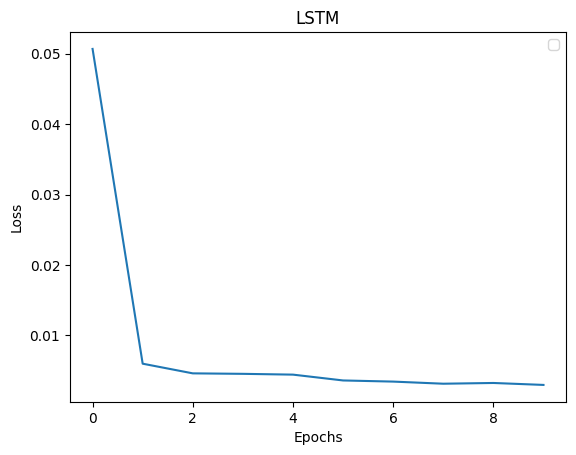

------------------------------------
Epoch 1/10
27/27 [==============================] - 92s 3s/step - loss: 0.0296
Epoch 2/10
27/27 [==============================] - 84s 3s/step - loss: 0.0036
Epoch 3/10
27/27 [==============================] - 84s 3s/step - loss: 0.0024
Epoch 4/10
27/27 [==============================] - 84s 3s/step - loss: 0.0022
Epoch 5/10
27/27 [==============================] - 84s 3s/step - loss: 0.0020
Epoch 6/10
27/27 [==============================] - 87s 3s/step - loss: 0.0018
Epoch 7/10
27/27 [==============================] - 84s 3s/step - loss: 0.0017
Epoch 8/10
27/27 [==============================] - 86s 3s/step - loss: 0.0019
Epoch 9/10
27/27 [==============================] - 84s 3s/step - loss: 0.0016
Epoch 10/10
27/27 [==============================] - 84s 3s/step - loss: 0.0016


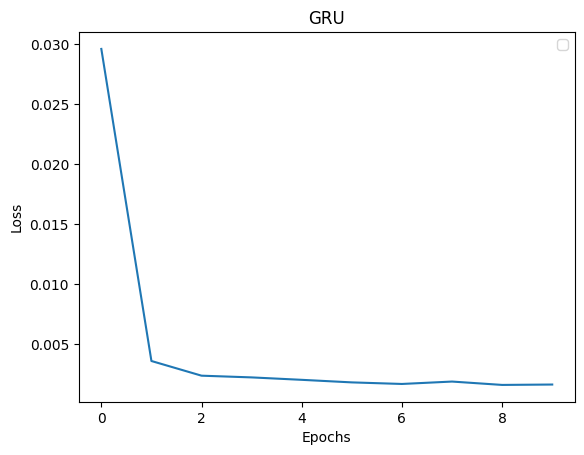

------------------------------------


In [18]:
models={"LSTM":model1,"GRU":model2}
for i,j in models.items():
    ### Training the model
    j.fit(X_train,y_train,epochs=10)
    ### Visualising the loss vs epoch curve
    plt.title(i)
    plt.plot(j.history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("------------------------------------")

In [ ]:
X_train.shape,X_test.shape

((0,), (0,))

2/2 [==============================] - 1s 416ms/step


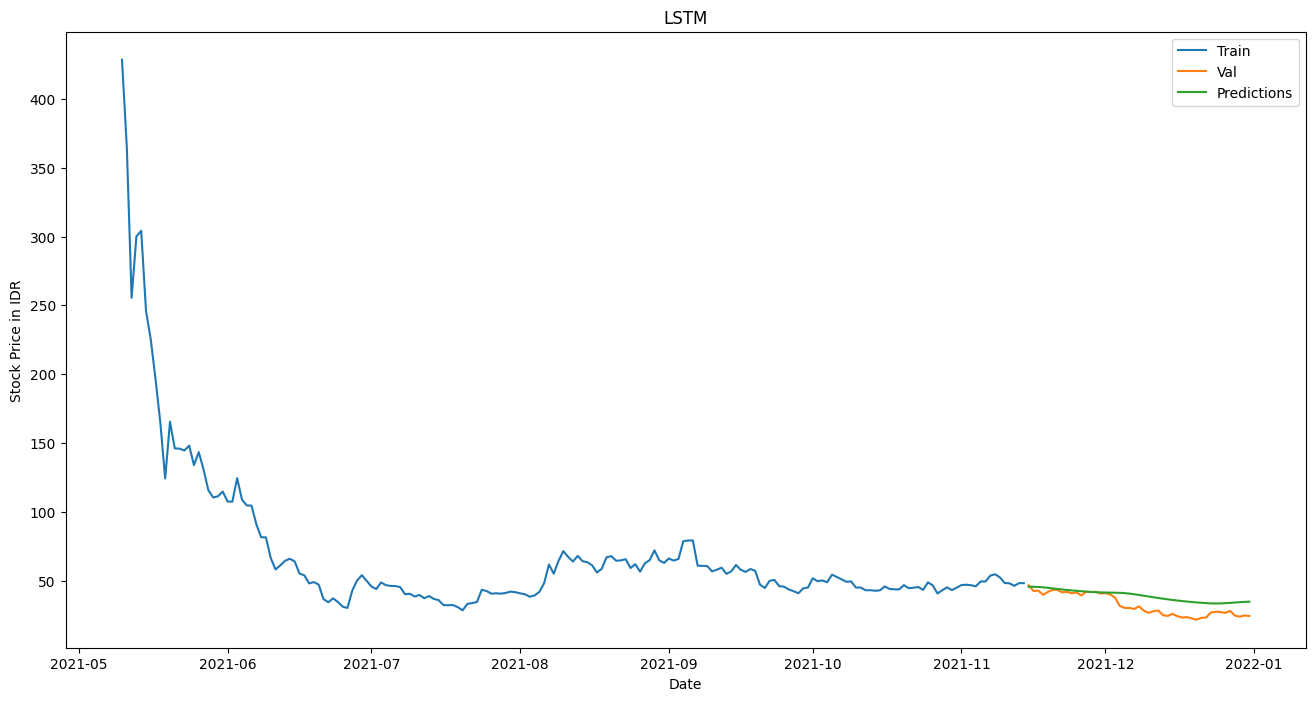



The MSE loss produced by LSTM model is: 1543.3727276061143


The RMSE loss produced by LSTM model is: 39.28578276687527


The MAPE loss produced by LSTM model is: inf


2/2 [==============================] - 3s 522ms/step


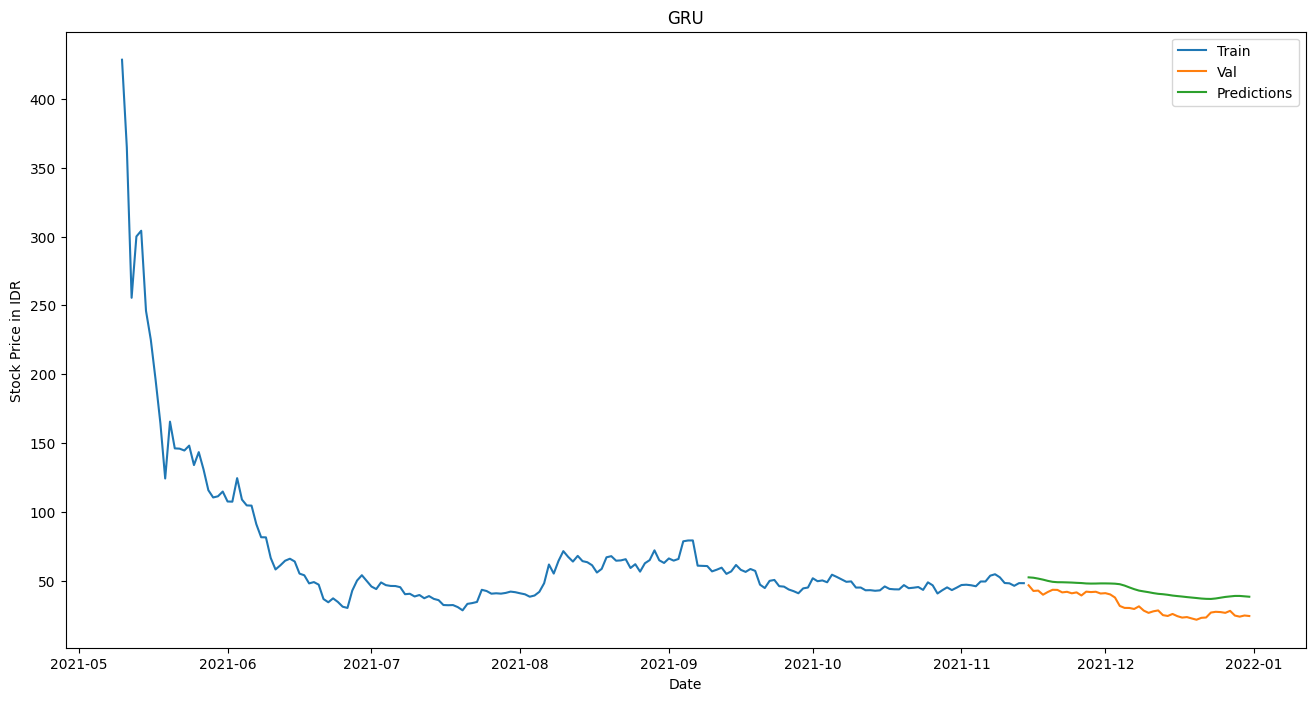



The MSE loss produced by GRU model is: 1935.2998800525004


The RMSE loss produced by GRU model is: 43.99204337209742


The MAPE loss produced by GRU model is: inf




In [ ]:
pred_={}

train=data[0:l] ### selecting the training data
valid=data[l:]  ### selecting the validation data

for i,j in models.items():
    ### Training the model
    pred=j.predict(X_test)
    pred=sc.inverse_transform(pred)   #### Rescaling the predictions

    valid["Predictions"]=pred

    plt.figure(figsize=(16,8))
    plt.title(f"{i}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price in IDR")
    plt.plot(train["Close"])
    plt.plot(valid[["Close","Predictions"]])
    plt.legend(["Train","Val","Predictions"])
    plt.show()

    print("\n")
    print(f"The MSE loss produced by {i} model is:",np.mean(((pred- y_test)**2)))
    print("\n")
    print(f"The RMSE loss produced by {i} model is:",np.sqrt(np.mean(((pred- y_test)**2))))
    print("\n")
    print(f"The MAPE loss produced by {i} model is:",mape(y_test, pred))
    print("\n")

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you have predictions for each model (e.g., pred_lstm and pred_gru)
pred_lstm = model1.predict(X_test)
pred_gru = model2.predict(X_test)

# Inverse transform predictions
pred_lstm = sc.inverse_transform(pred_lstm)
pred_gru = sc.inverse_transform(pred_gru)

# Calculate MSE, RMSE, and MAPE for LSTM
mse_lstm = mean_squared_error(y_test, pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = mape(y_test, pred_lstm)

# Calculate MSE, RMSE, and MAPE for GRU
mse_gru = mean_squared_error(y_test, pred_gru)
rmse_gru = np.sqrt(mse_gru)
mape_gru = mape(y_test, pred_gru)

# Print results
print("LSTM Model:")
print("MSE: ", mse_lstm)
print("RMSE: ", rmse_lstm)
print("MAPE: ", mape_lstm)
print("\n")

print("GRU Model:")
print("MSE: ", mse_gru)
print("RMSE: ", rmse_gru)
print("MAPE: ", mape_gru)


8/8 [==============================] - 9s 985ms/step
LSTM Model:
MSE:  0.3823248325500224
RMSE:  0.6183242131358131
MAPE:  3.0719683492357


GRU Model:
MSE:  0.37779981640164945
RMSE:  0.6146542250742685
MAPE:  2.974678858815575
